In [1]:
import xarray as xr
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
from compute_rri import ecg_job
from compute_resp_features import respiration_features_job
from compute_eda import eda_job
from compute_bandpower import bandpower_job
from compute_power_at_resp import power_at_resp_job
from params import *
from bibliotheque import get_pos
import physio
from configuration import base_folder
import os

In [2]:
metrics = {
    'hrv':['HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad','HRV_CV', 'HRV_MCV', 'HRV_RMSSD'],
    'eda':['Tonic', 'N_SCR', 'SCR_Height','SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime'],
    'resp':['cycle_duration', 'inspi_duration', 'expi_duration', 'cycle_freq',
       'cycle_ratio', 'inspi_volume', 'expi_volume', 'total_amplitude',
       'inspi_amplitude', 'expi_amplitude', 'total_volume'],
    'bandpower':['power_integral','power_median'],
    'power_at_resp':['max_eeg'],
    'rsa':['rsa_amplitude']
}

In [3]:
def get_hrv(run_keys):
    concat = []
    for run_key in run_keys:
        participant,session = run_key.split('_')
        peaks = ecg_job.get(run_key)['ecg_peaks']
        metrics = physio.compute_ecg_metrics(peaks, srate)
        df = metrics.to_frame().T
        df.insert(0 , 'session', session)
        df.insert(0 , 'participant', participant)
        concat.append(df)
    hrv = pd.concat(concat)
    return hrv

In [4]:
def get_eda(run_keys):
    concat = []
    for run_key in run_keys:
        concat.append(eda_job.get(run_key).to_dataframe())
    eda = pd.concat(concat)
    return eda

In [5]:
def get_power_at_resp(run_keys):
    concat = []
    for run_key in run_keys:
        participant, session = run_key.split('_')
        power_at_resp_participant = power_at_resp_job.get(run_key).to_dataframe()
        concat.append(power_at_resp_participant)
    power_at_resp = pd.concat(concat).reset_index(drop = True)
    return power_at_resp

In [6]:
def get_bandpower(run_keys):
    concat = []
    for run_key in run_keys:
        concat.append(bandpower_job.get(run_key).to_dataframe())
    bandpower = pd.concat(concat)
    return bandpower

In [7]:
def get_resp_features(run_keys):
    concat = []

    for run_key in run_keys:
        participant, session = run_key.split('_')
        features = respiration_features_job.get(run_key).to_dataframe()
        features.insert(0, 'session', session)
        features.insert(0, 'participant', participant)
        features = features.groupby(['participant','session']).median().reset_index()
        concat.append(features)
    resp = pd.concat(concat)
    return resp

In [8]:
def get_rsa():
    return pd.read_excel(base_folder / 'Tables' / 'rsa.xlsx', index_col = 0)

In [9]:
hrv = get_hrv(run_keys)

In [10]:
eda = get_eda(run_keys)

In [11]:
resp = get_resp_features(run_keys)

In [12]:
bandpower = get_bandpower(run_keys)

In [13]:
alpha = bandpower[bandpower['band'] == 'alpha'].groupby(['participant','session']).mean(numeric_only = True).reset_index()

In [14]:
power_at_resp = get_power_at_resp(run_keys)

In [15]:
power_at_resp_gby = power_at_resp.groupby(['participant','session']).mean(numeric_only = True).reset_index()

In [16]:
rsa = get_rsa()

In [17]:
concat = []

for label, df in zip(['hrv','eda','resp','bandpower','power_at_resp','rsa'],[hrv, eda, resp, alpha, power_at_resp_gby, rsa]):
    concat.append(df[metrics[label]].reset_index(drop=True))

In [18]:
grouping = pd.concat(concat, axis = 1)

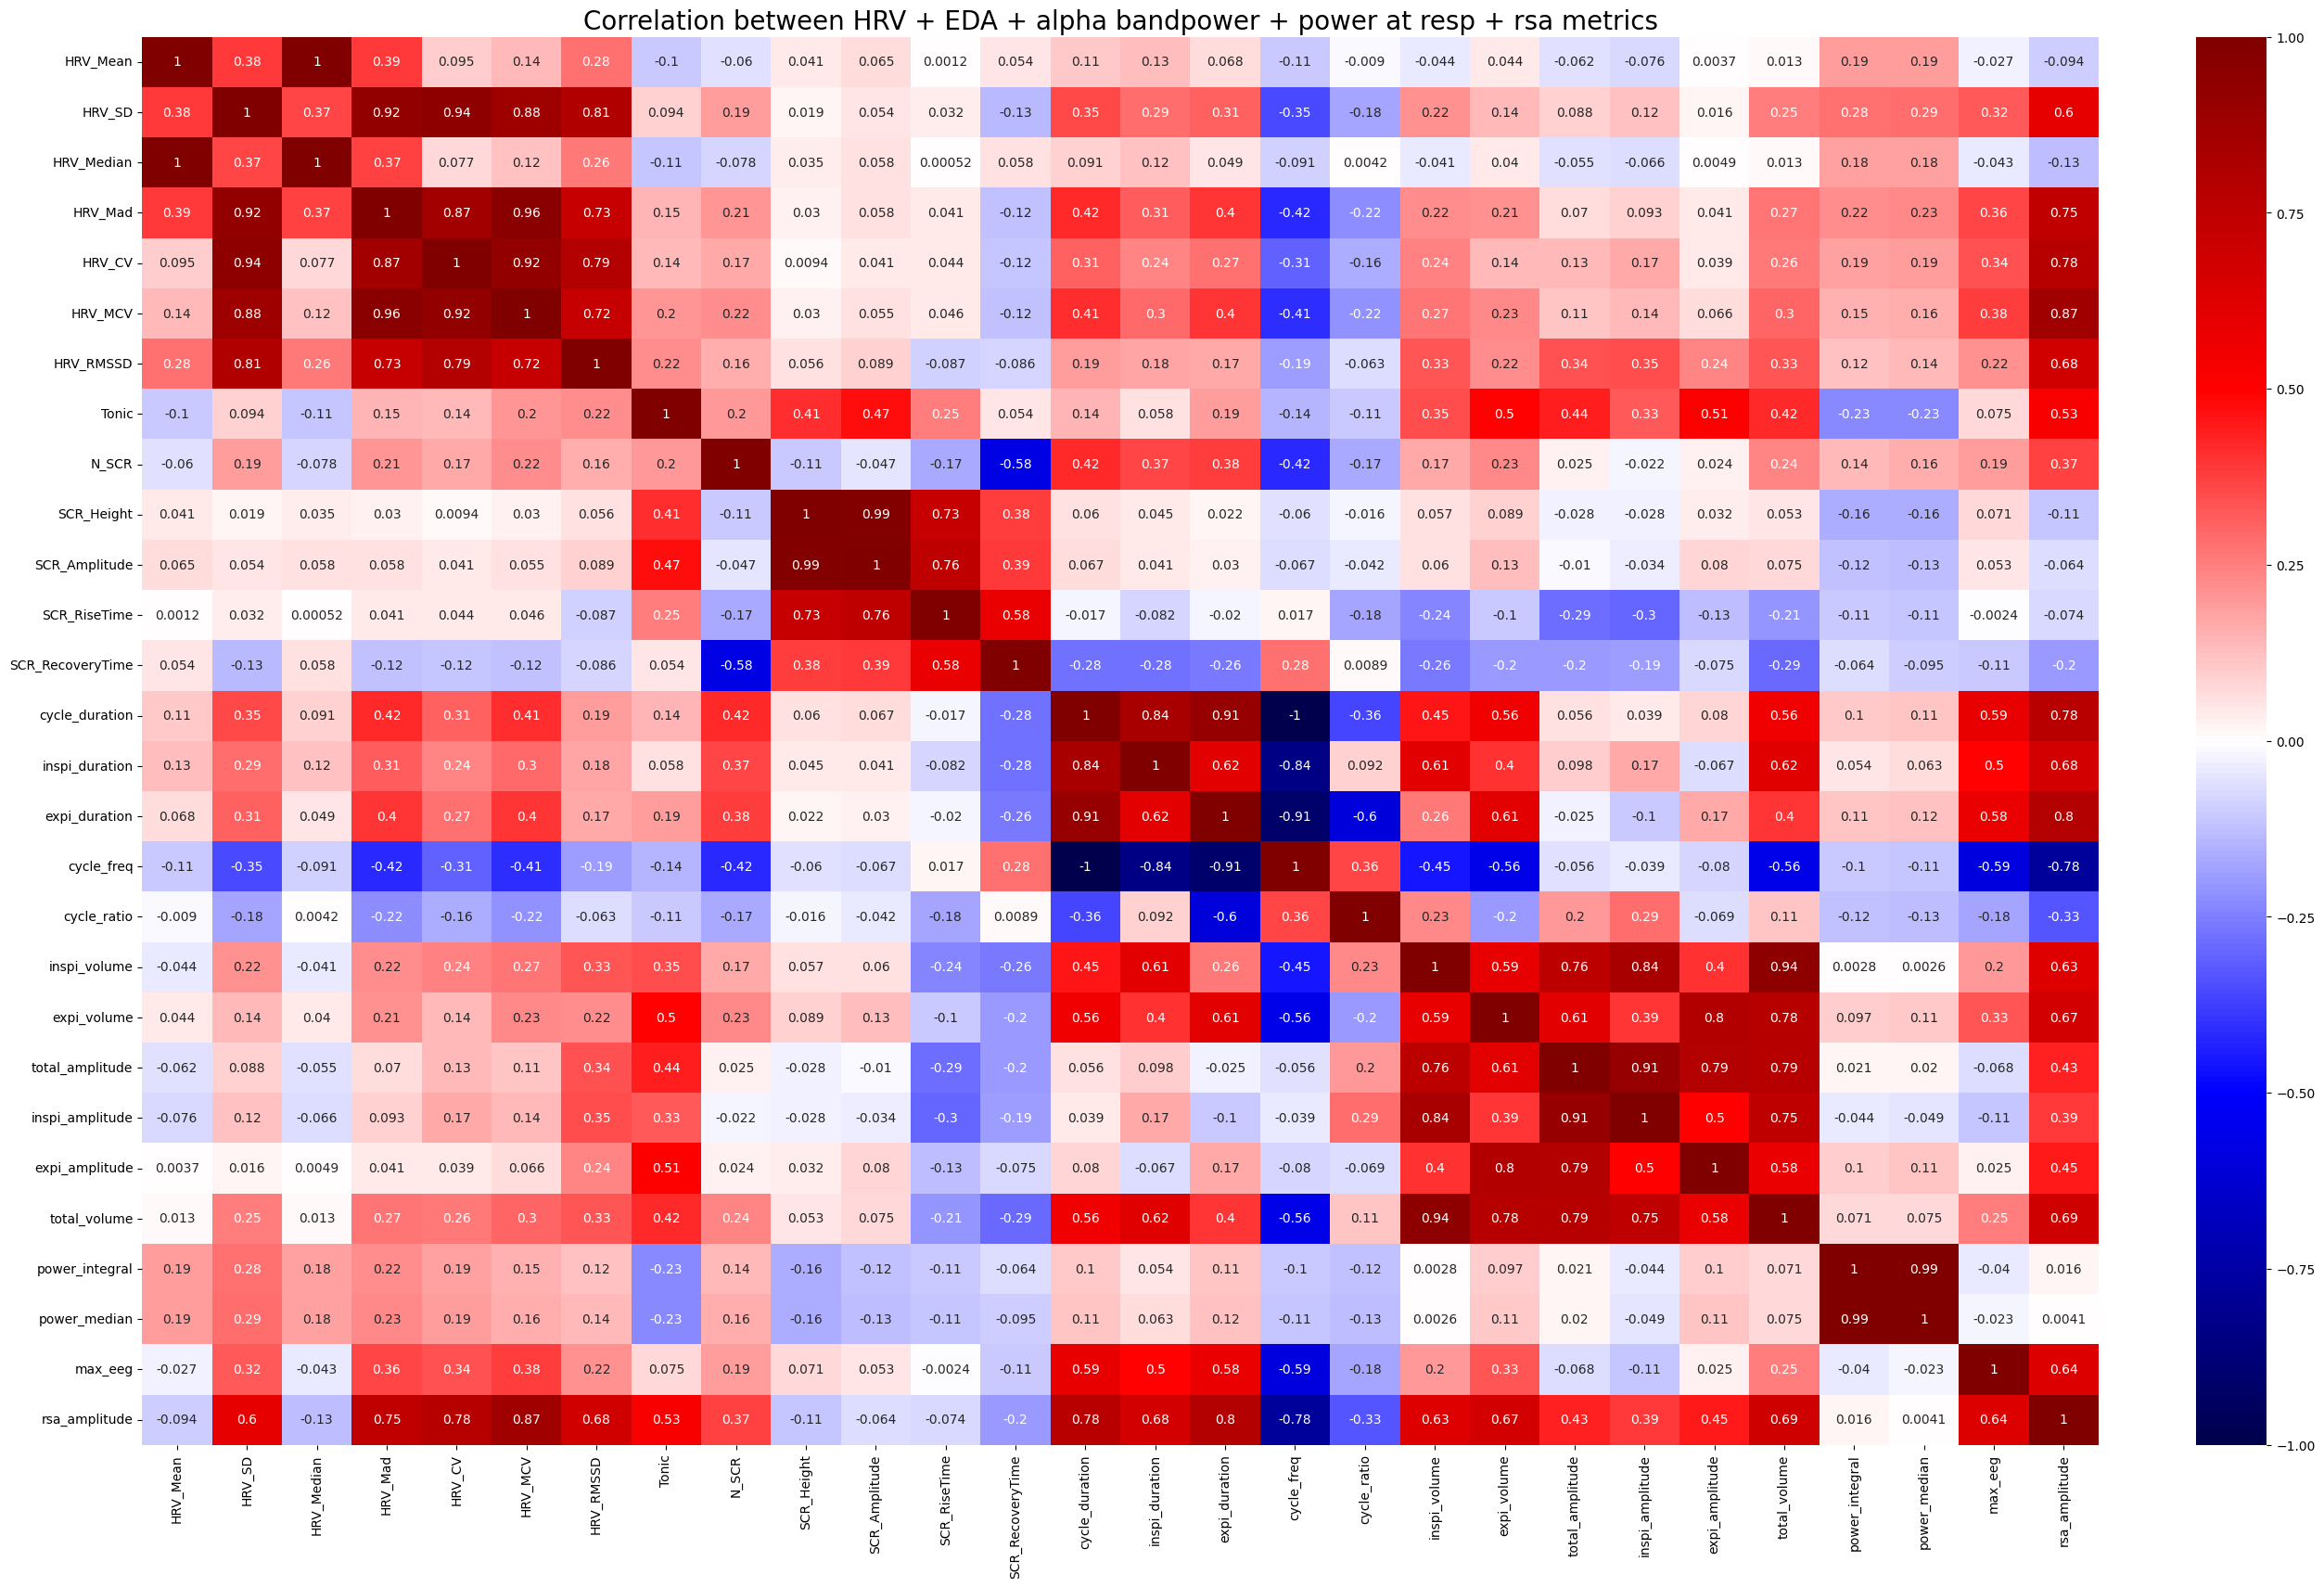

In [19]:
fig, ax = plt.subplots(figsize =(25, 17), constrained_layout = True)
sns.heatmap(grouping.corr('spearman'), annot = True, vmin = -1, vmax = 1, cmap = 'seismic',ax=ax)
ax.set_title('Correlation between HRV + EDA + alpha bandpower + power at resp + rsa metrics', fontsize = 20)
file = base_folder / 'Figures' / 'big_correlation.png'
fig.savefig(file, bbox_inches = 'tight')

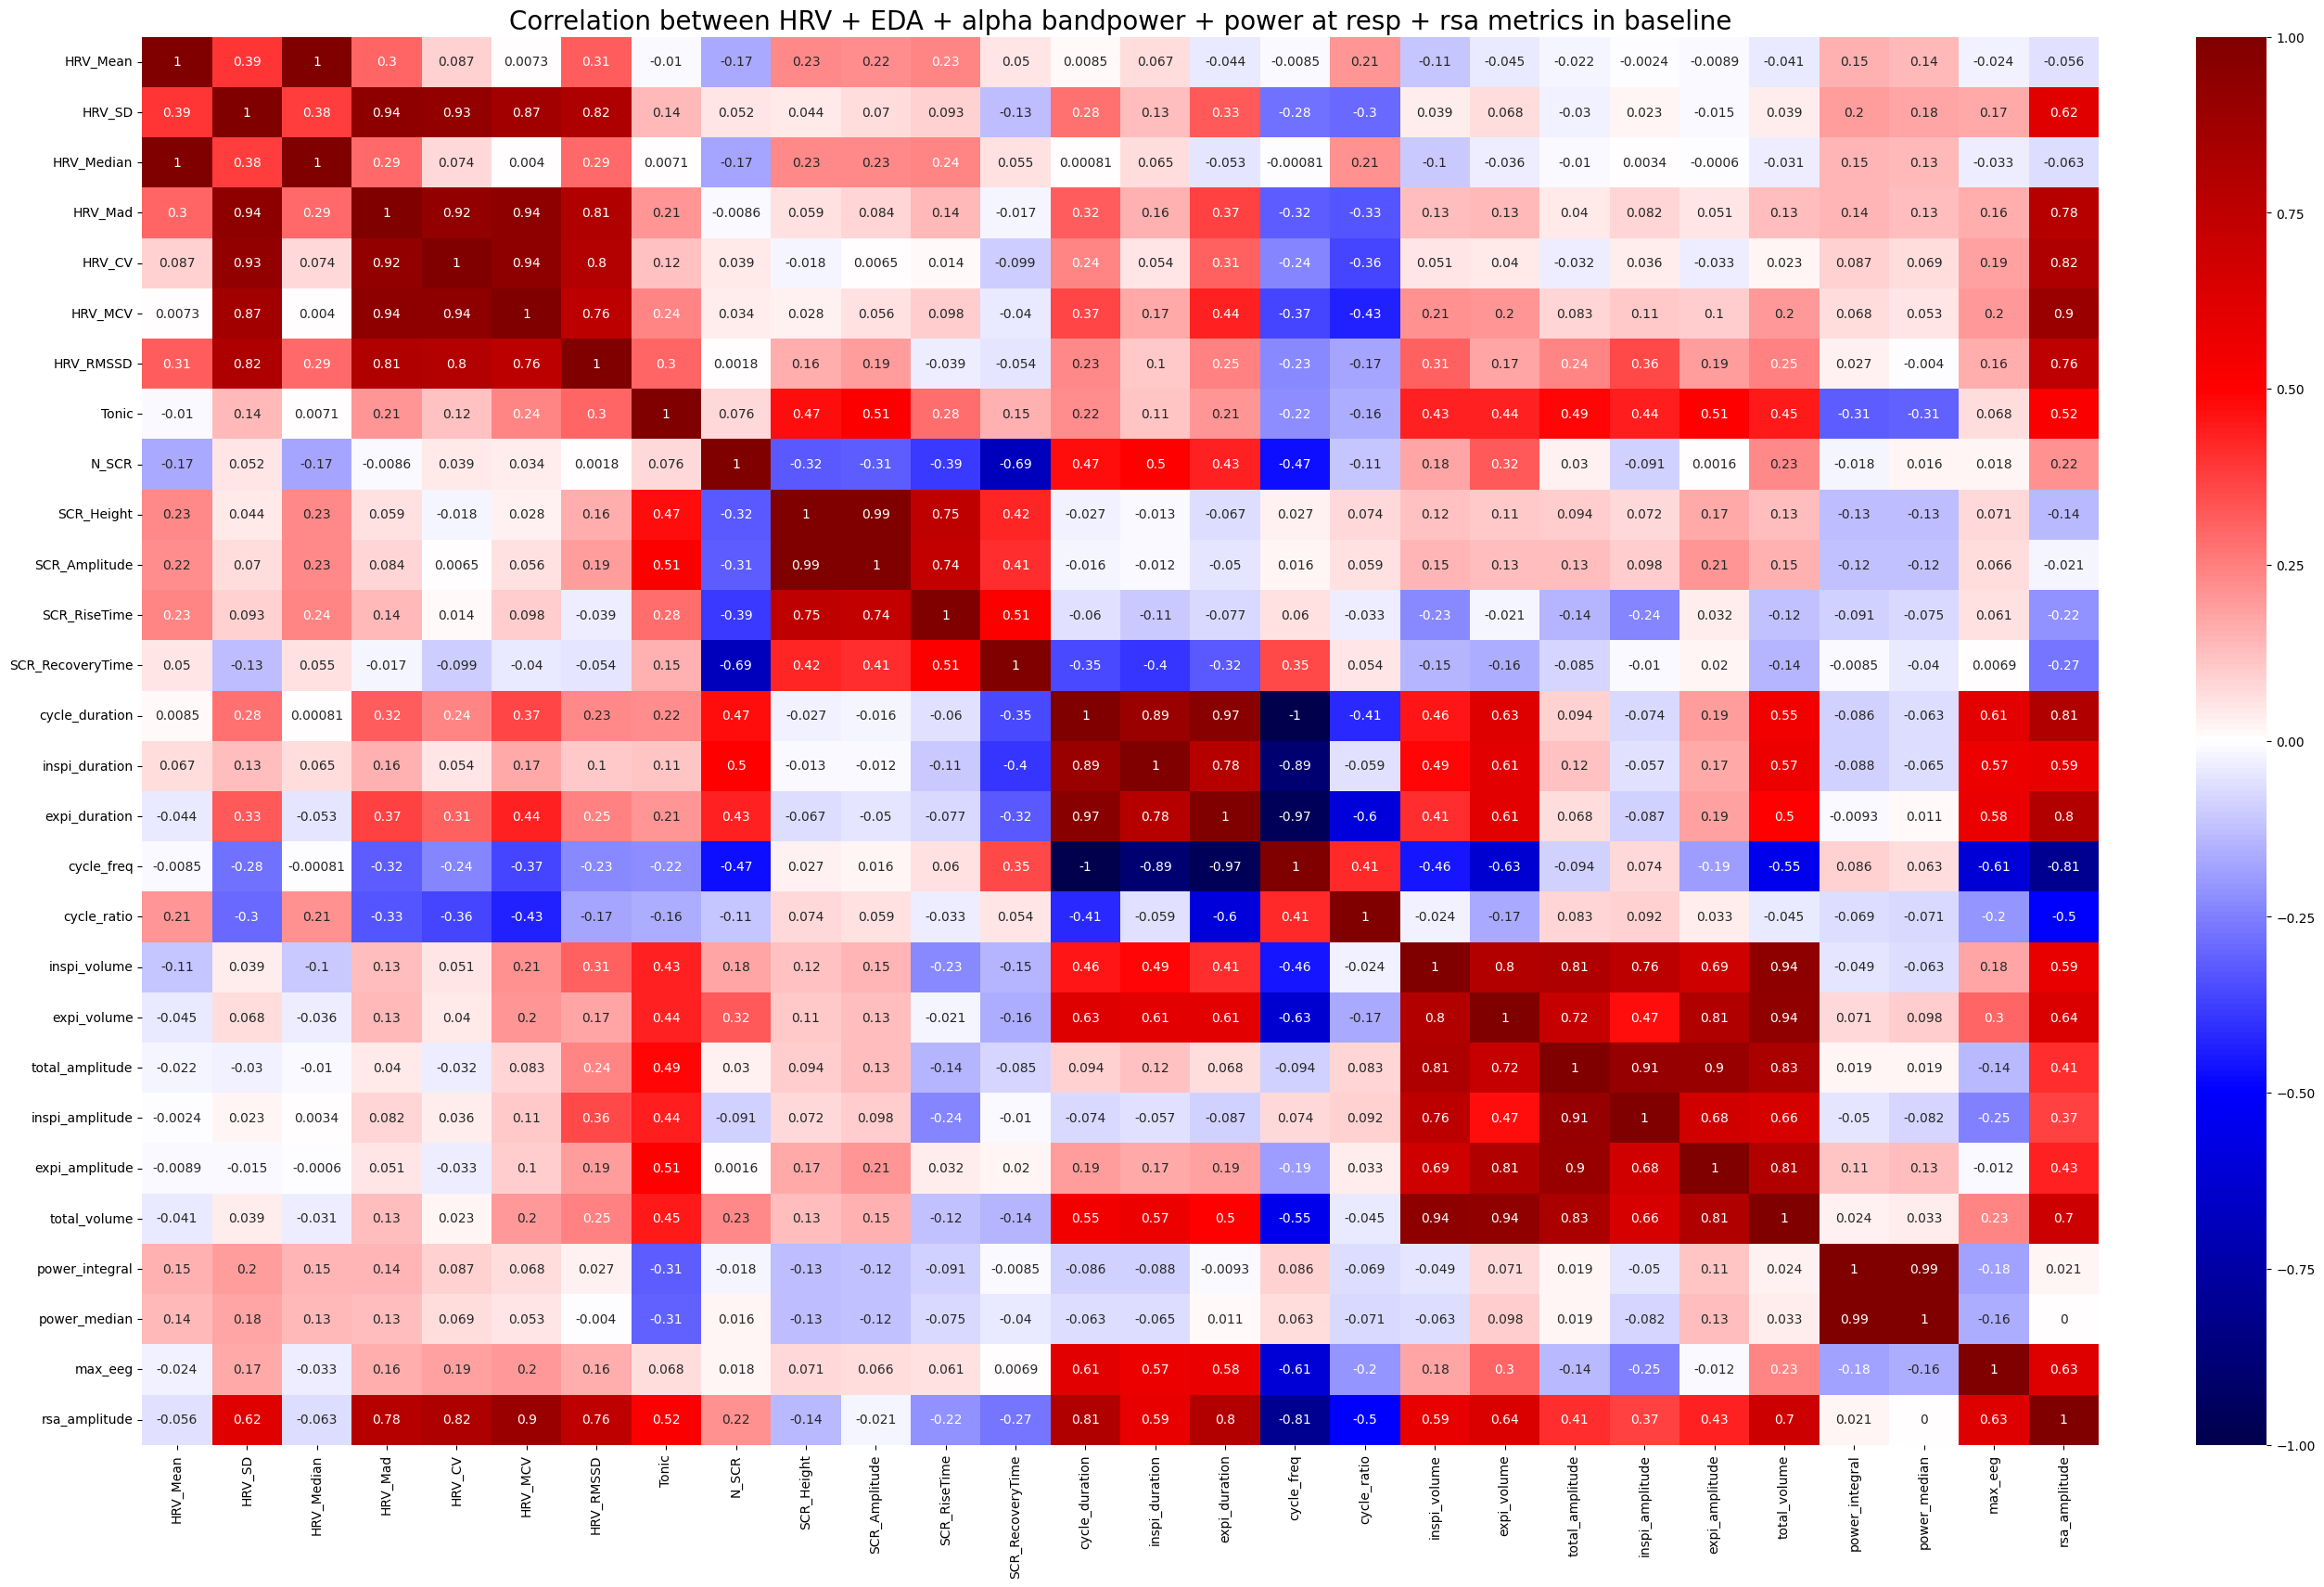

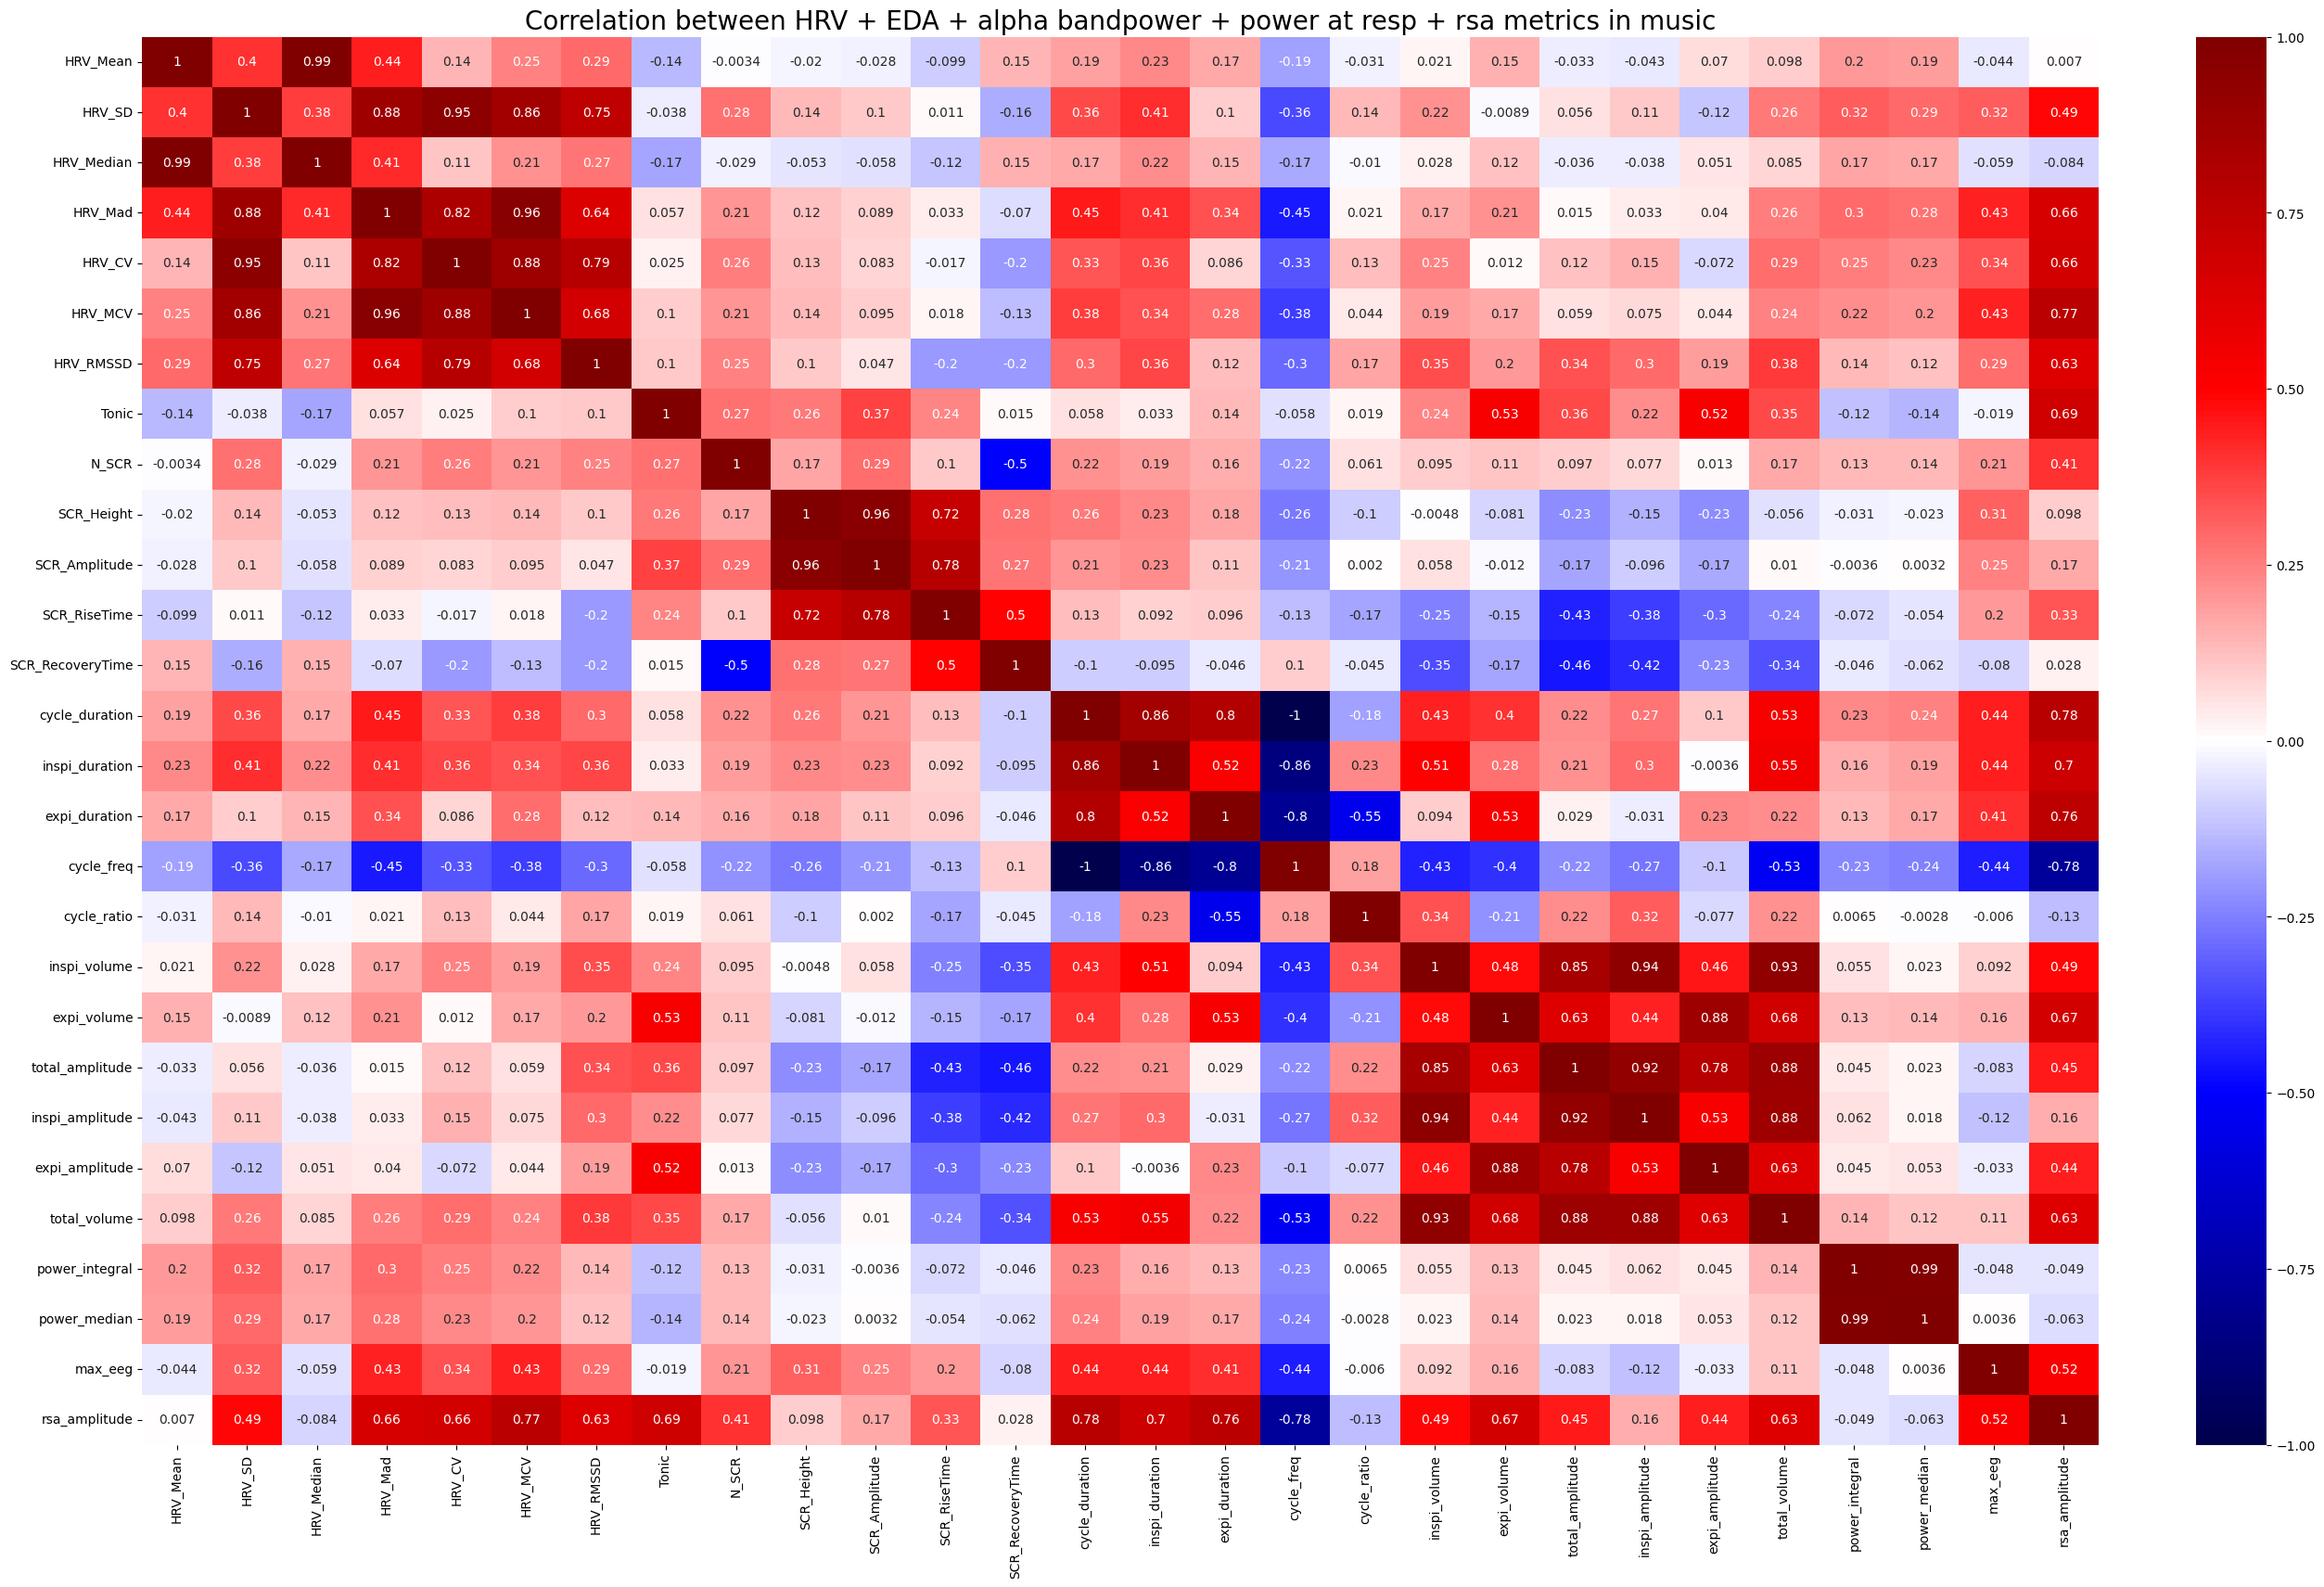

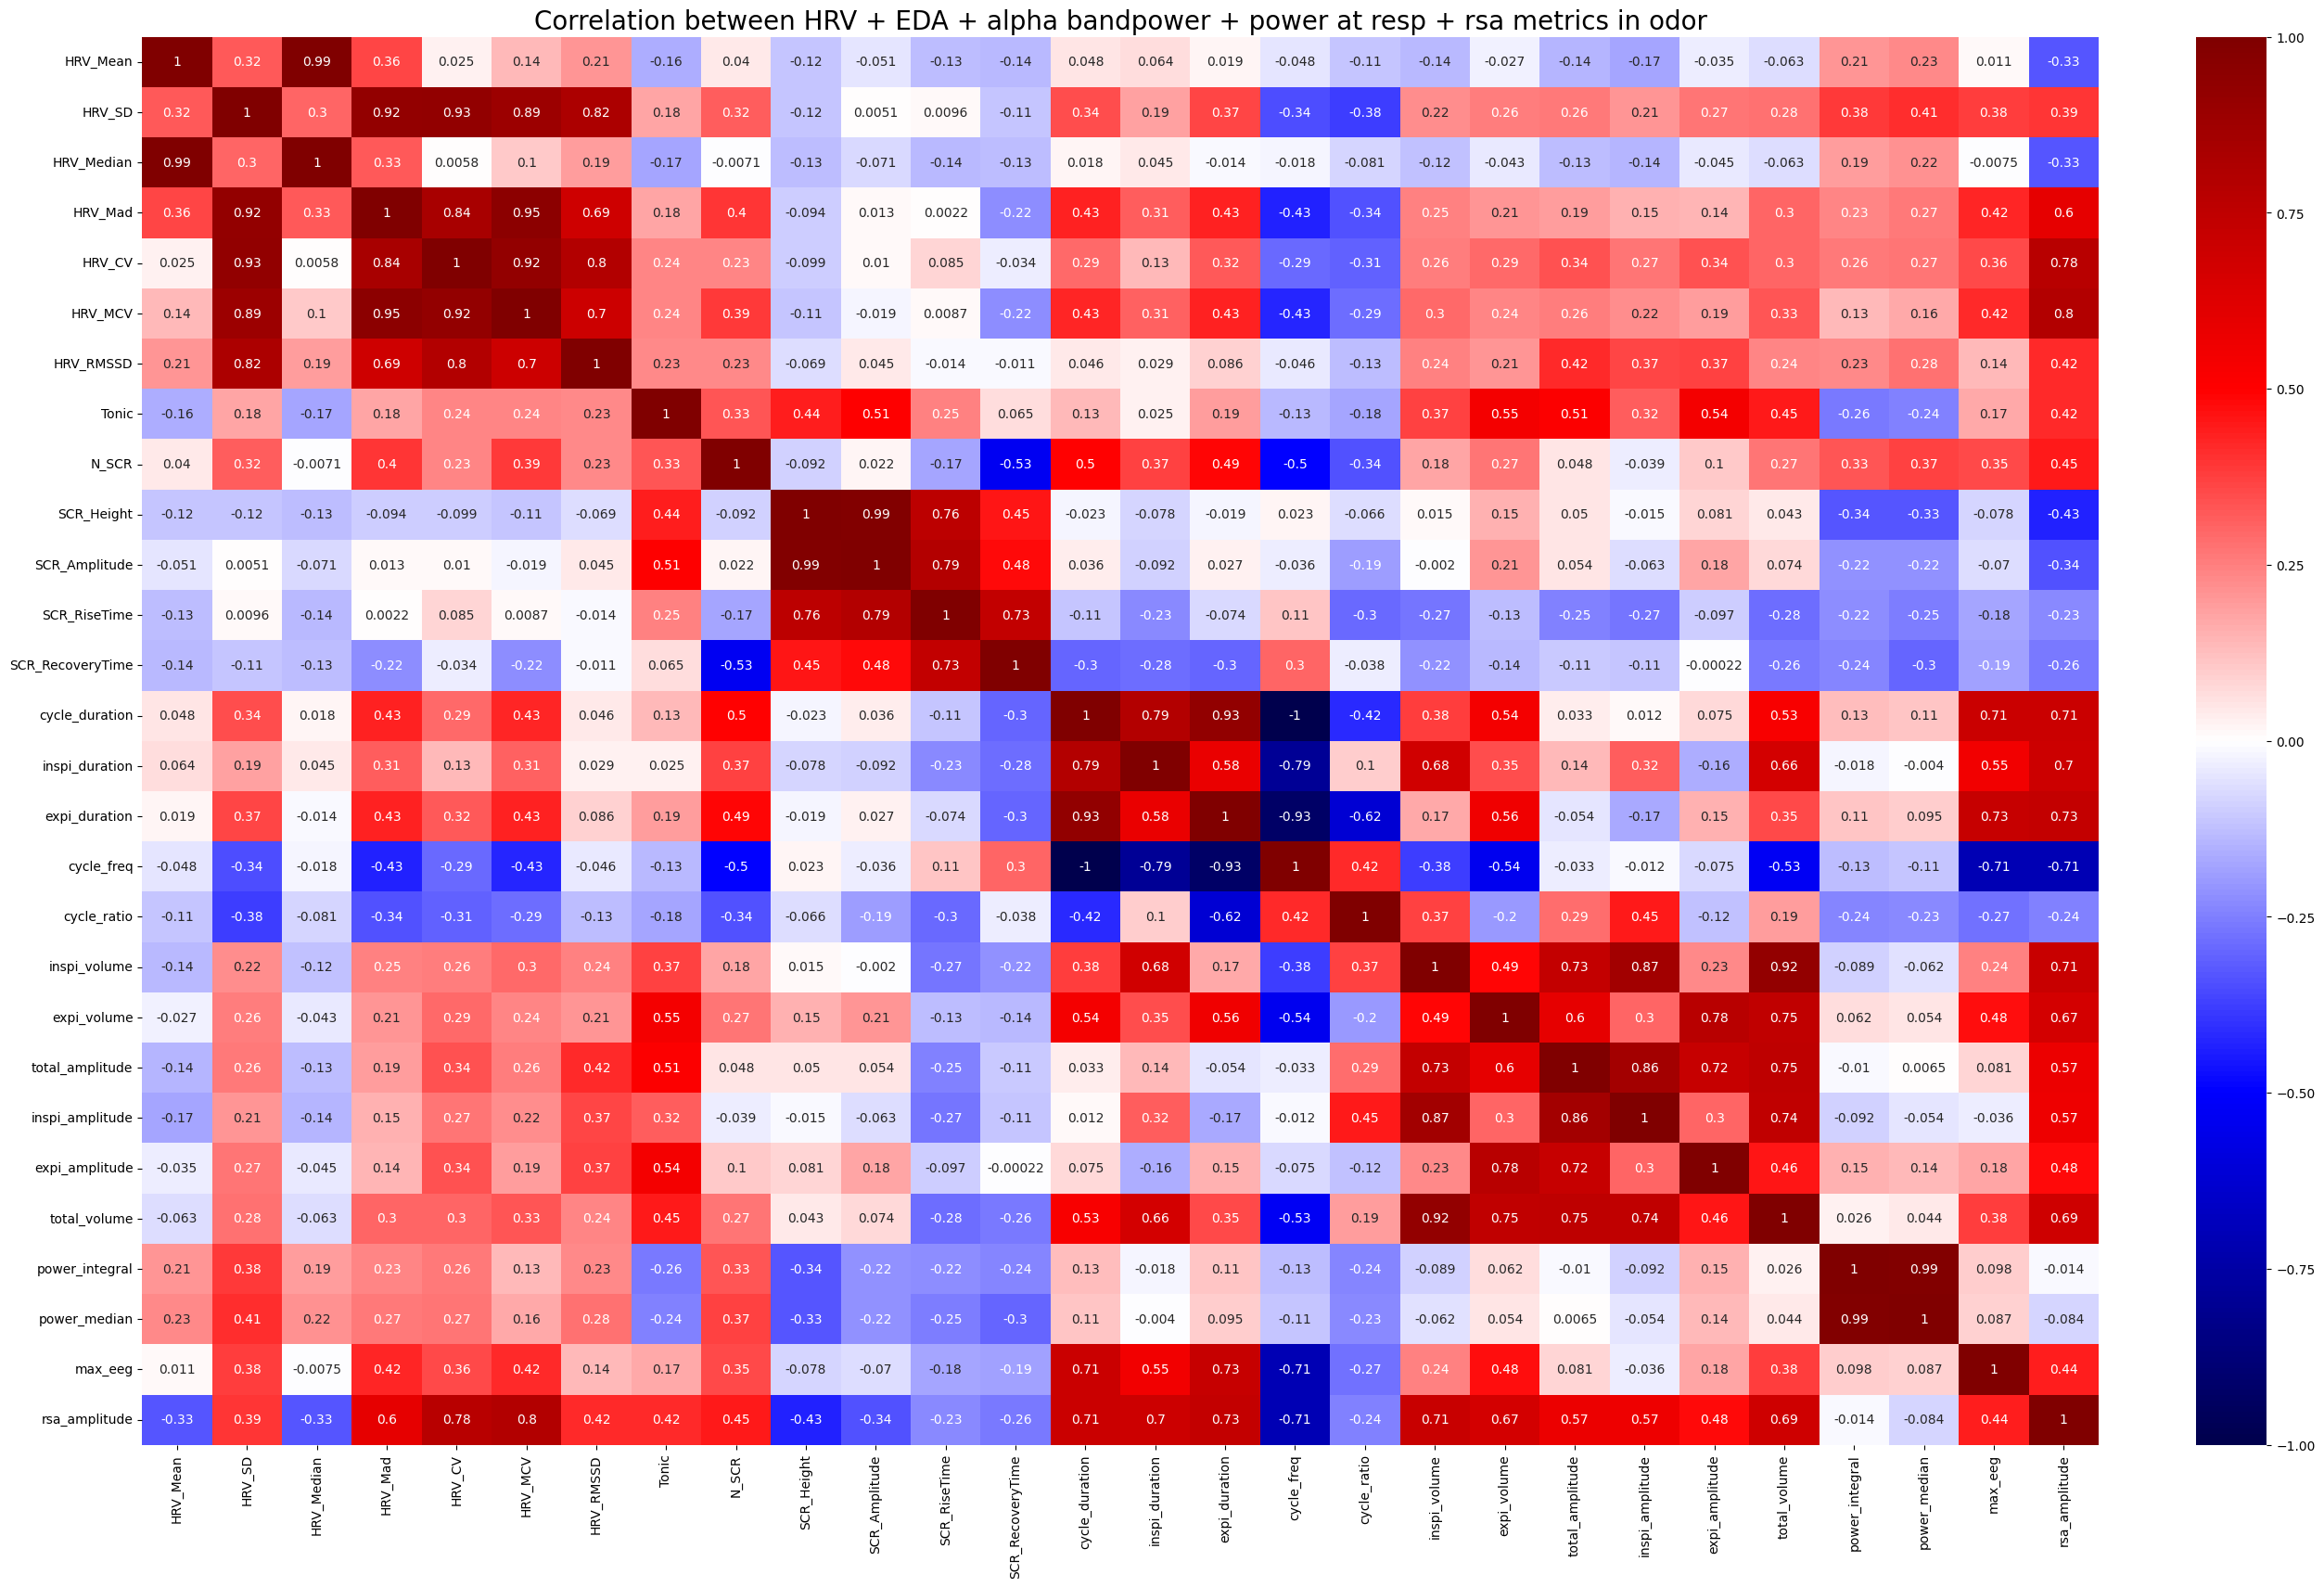

In [23]:
corrs = {}
for ses in session_keys:
    concat = []
    for label, df in zip(['hrv','eda','resp','bandpower','power_at_resp','rsa'],[hrv, eda, resp, alpha, power_at_resp_gby, rsa]):
        df_ses = df[df['session'] == ses][metrics[label]]
        concat.append(df_ses.reset_index(drop=True))
    grouping = pd.concat(concat, axis = 1)
    fig, ax = plt.subplots(figsize =(25, 17), constrained_layout = True)
    corr = grouping.corr('spearman')
    corrs[ses] = corr
    sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, cmap = 'seismic',ax=ax)
    ax.set_title(f'Correlation between HRV + EDA + alpha bandpower + power at resp + rsa metrics in {ses}', fontsize = 20)
    file = base_folder / 'Figures' / f'big_correlation_{ses}.png'
    fig.savefig(file, bbox_inches = 'tight')

<AxesSubplot: >

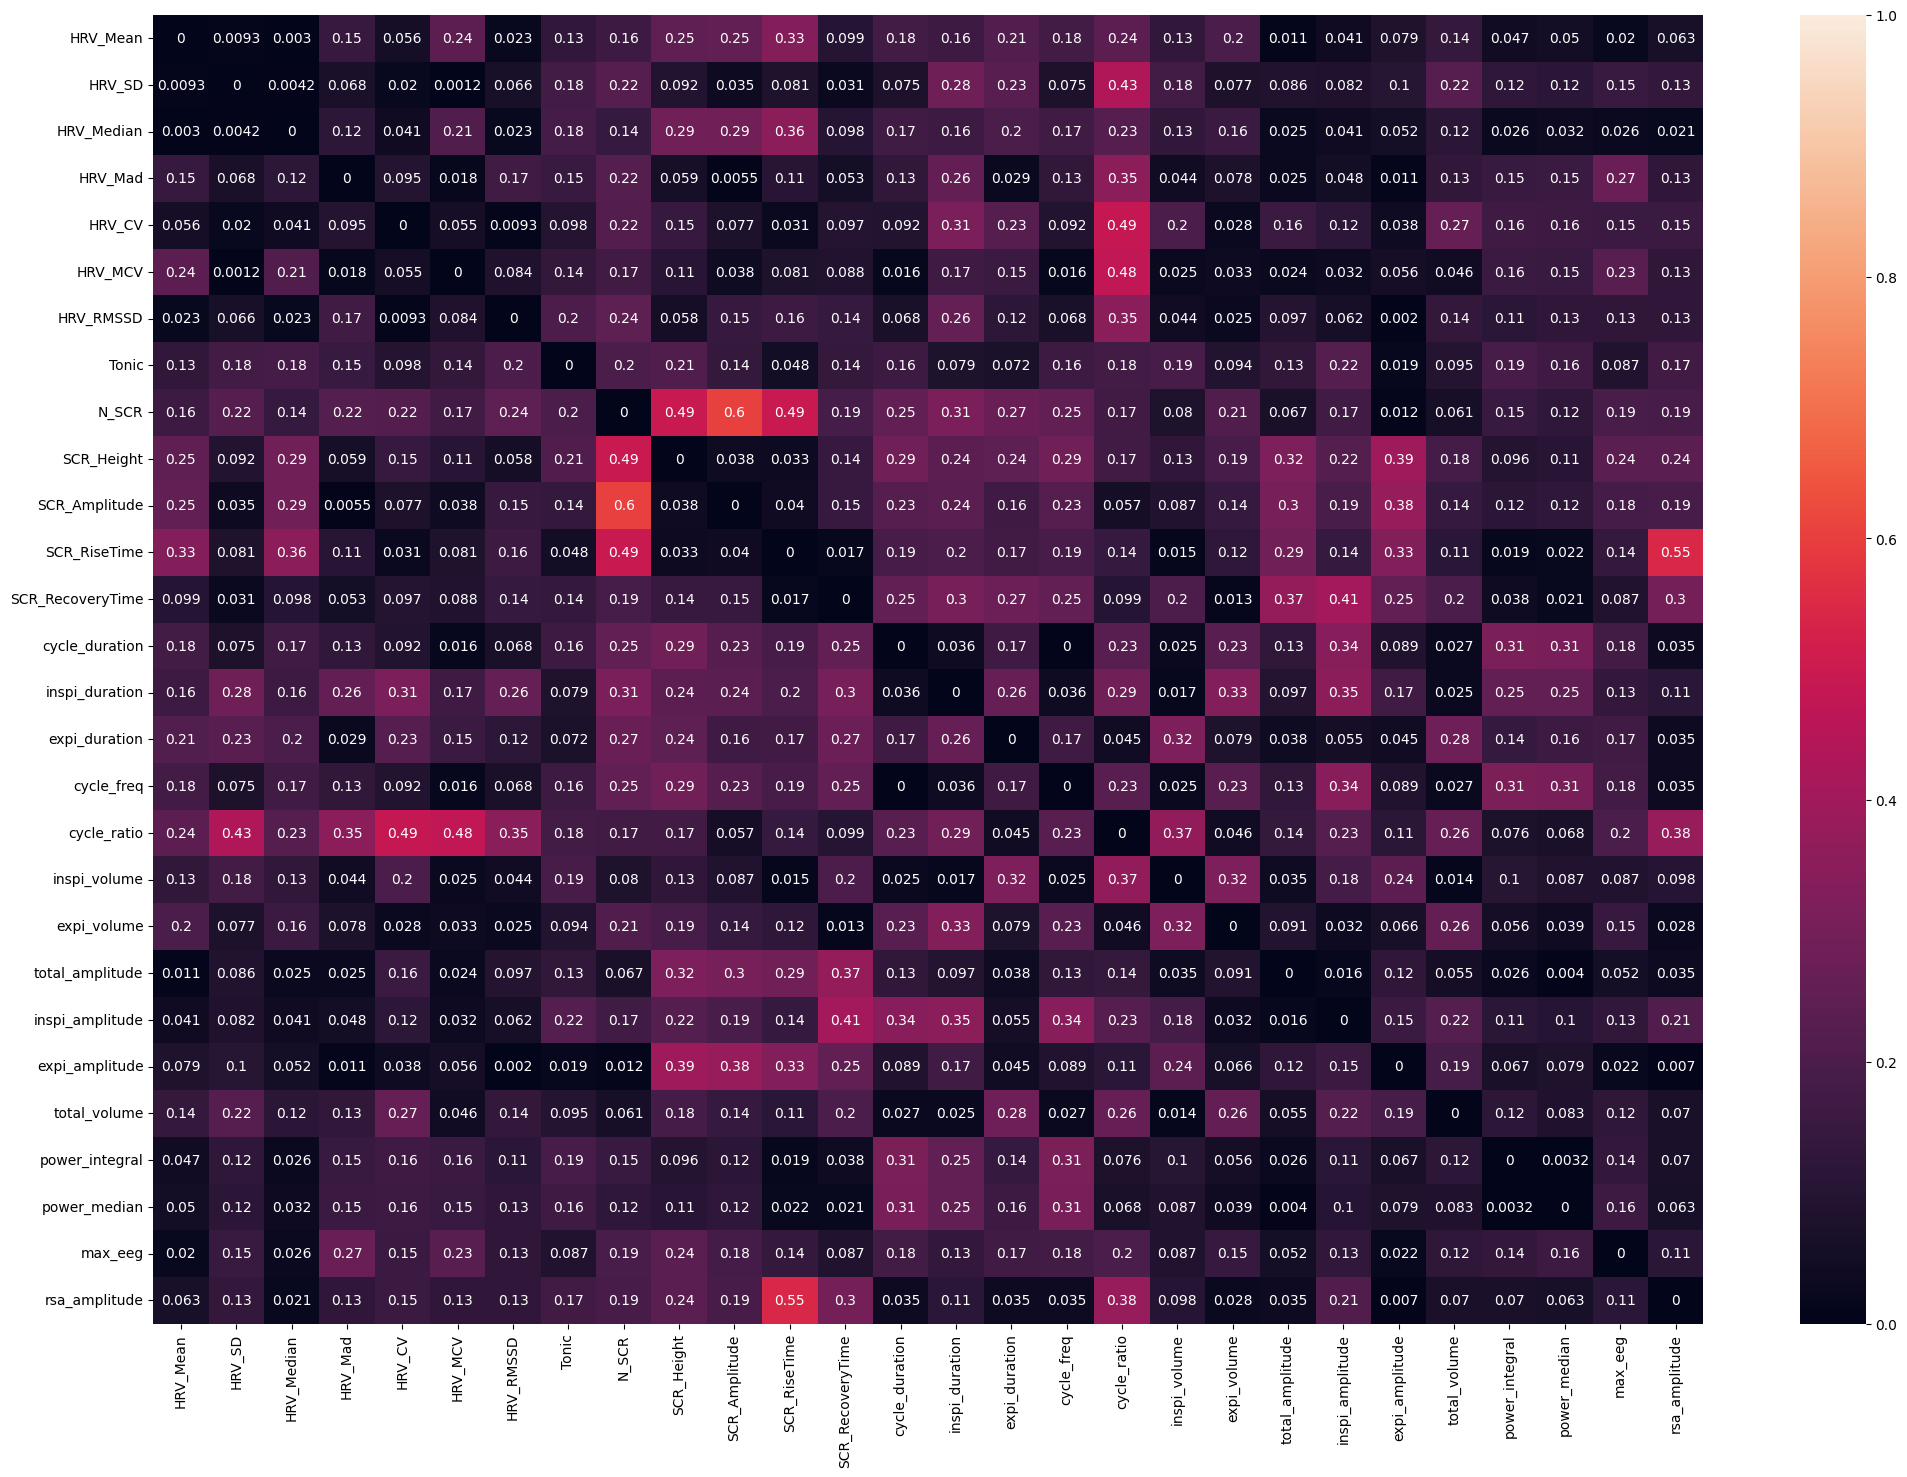

In [32]:
fig, ax = plt.subplots(figsize = (25,17))
sns.heatmap(np.abs(corrs['music'] - corrs['baseline']), annot = True, vmin = 0, vmax = 1, ax=ax)

<AxesSubplot: >

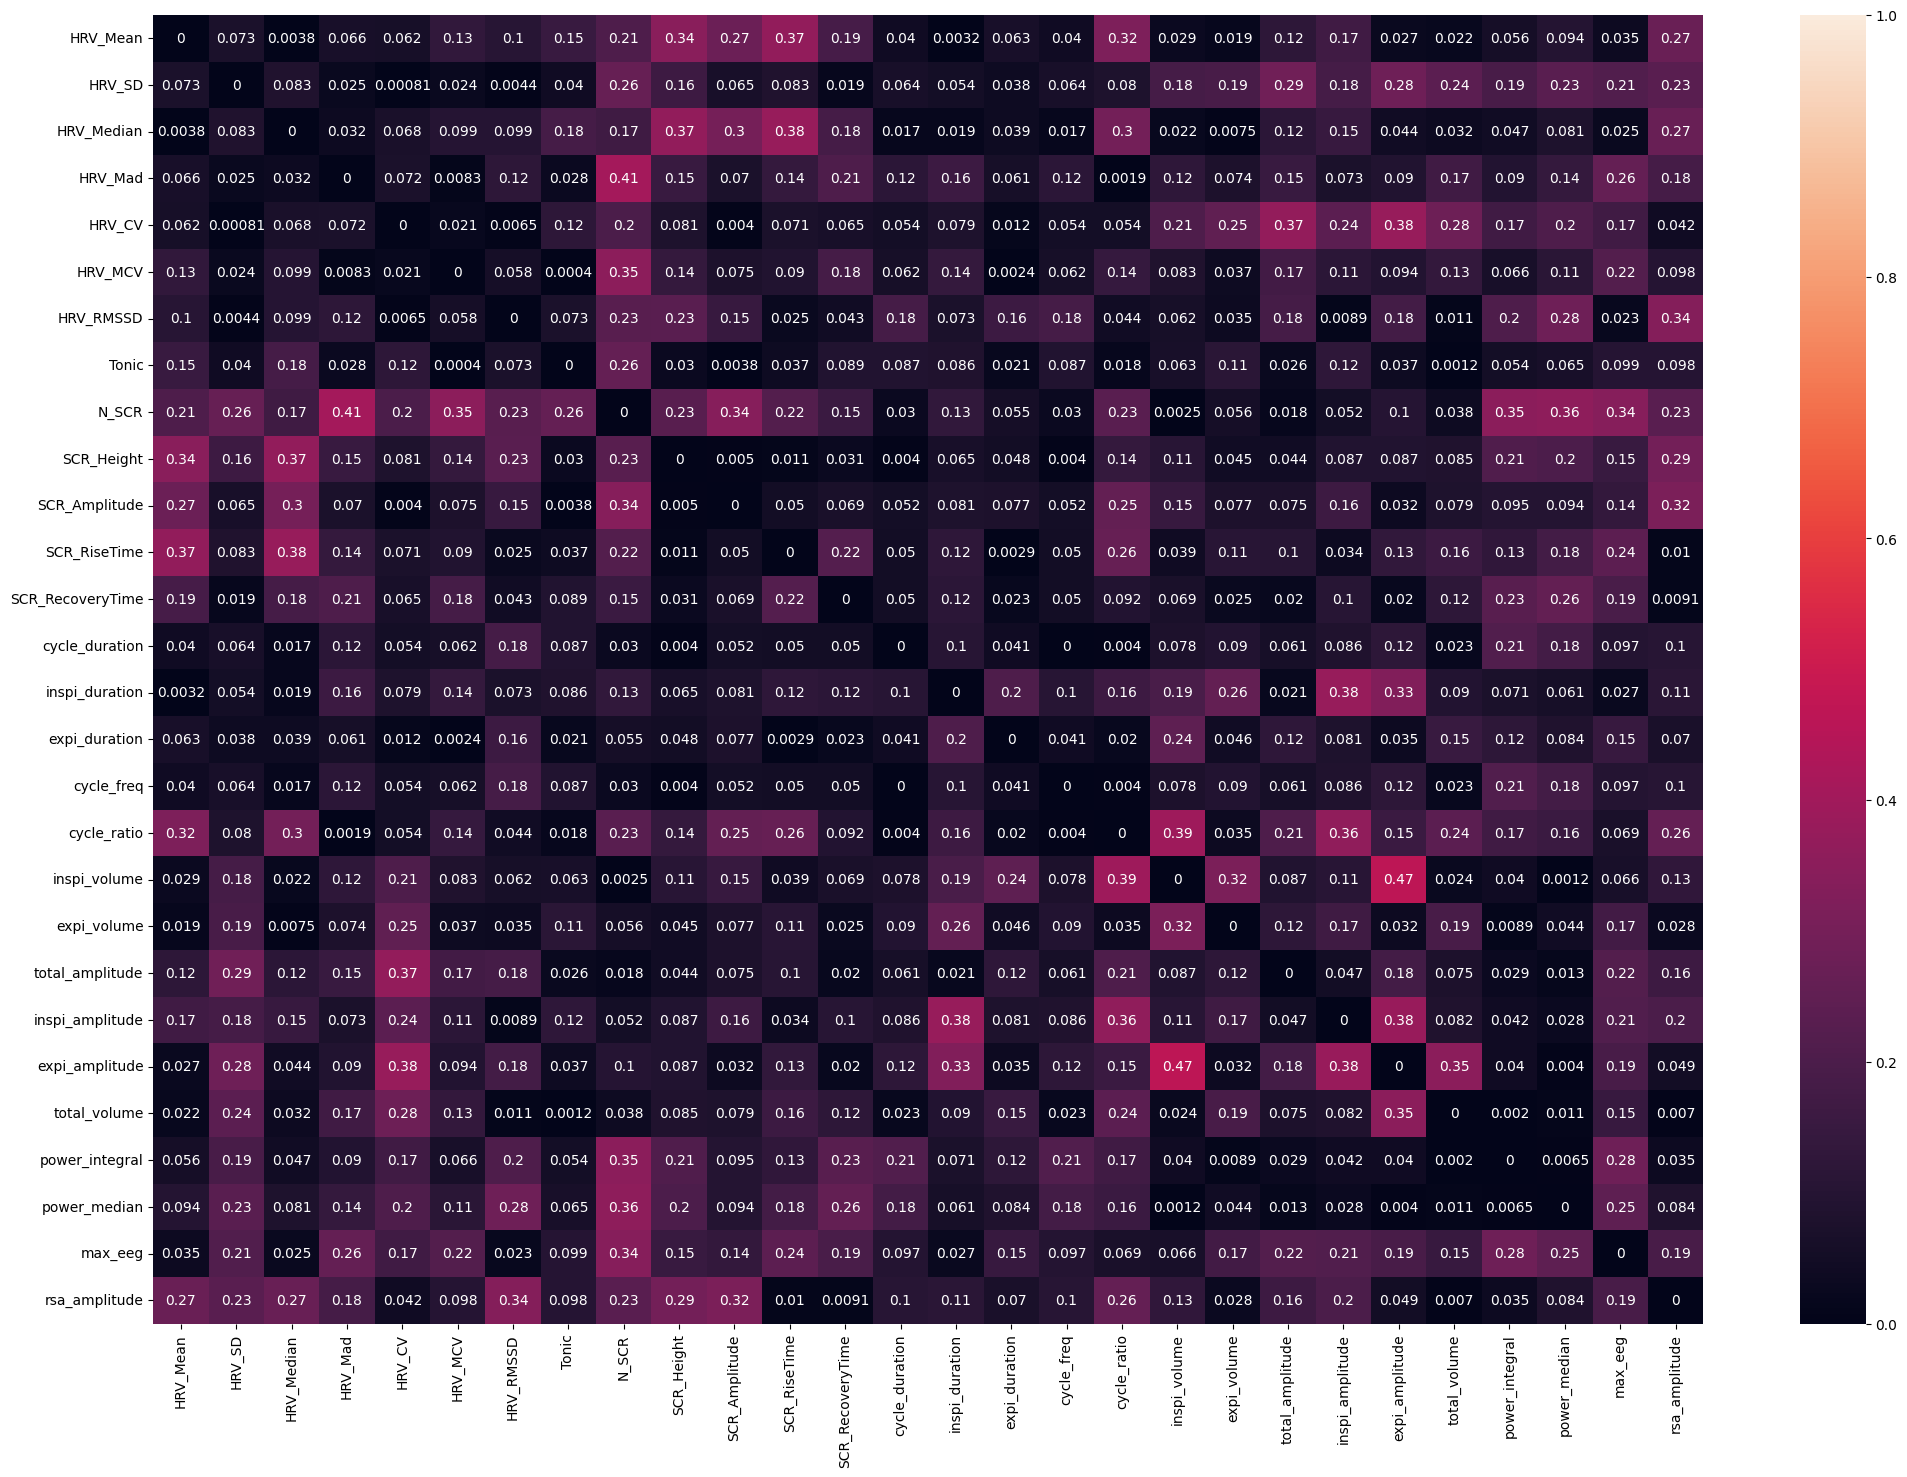

In [33]:
fig, ax = plt.subplots(figsize = (25,17))
sns.heatmap(np.abs(corrs['odor'] - corrs['baseline']), annot = True, vmin = 0, vmax = 1, ax=ax)

<AxesSubplot: >

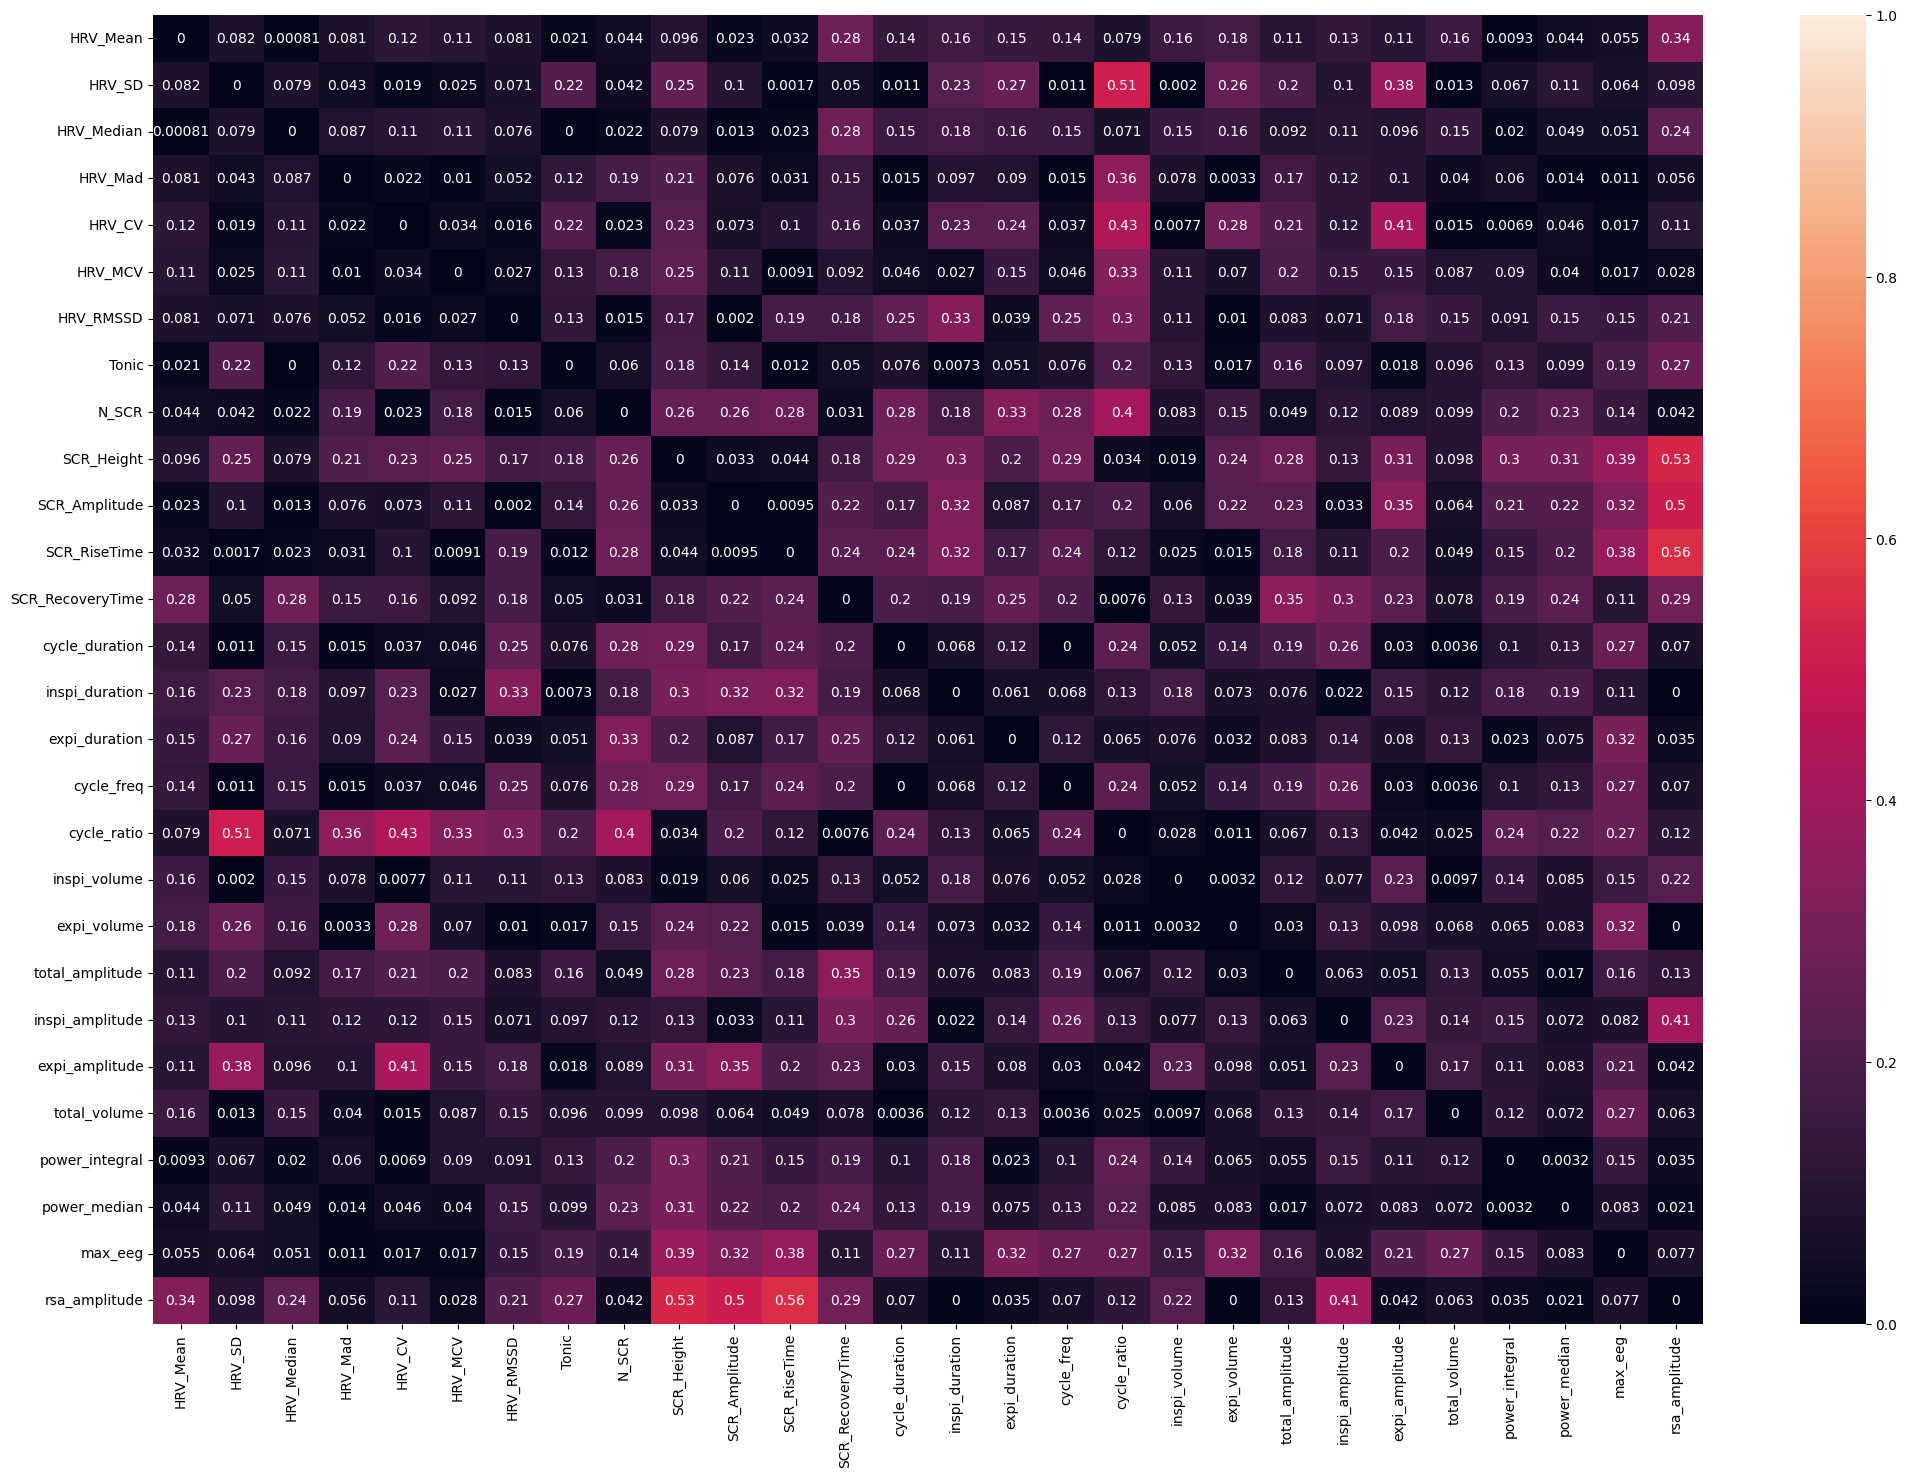

In [34]:
fig, ax = plt.subplots(figsize = (25,17))
sns.heatmap(np.abs(corrs['odor'] - corrs['music']), annot = True, vmin = 0, vmax = 1, ax=ax)